# REP (Reproducible Experiment Platform)



# Tutorial for Flavours of Physics Challenge 

an almost real-life example of physics analysis with [yandex/REP](https://github.com/yandex/rep).



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!wget https://www.dropbox.com/s/yxyw00os79cg19n/training.root?dl=0 -O tau_data/training.root
!wget https://www.dropbox.com/s/gfefr8036dmmbsr/check_agreement.root?dl=0 -O tau_data/check_agreement.root

--2016-02-18 00:44:39--  https://www.dropbox.com/s/yxyw00os79cg19n/training.root?dl=0
Resolving www.dropbox.com... 108.160.172.206, 108.160.172.238
Connecting to www.dropbox.com|108.160.172.206|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://dl.dropboxusercontent.com/content_link/LrBFpT3oW9JGoSoeXsCu6PD4aMgMPfyTFGIzbI1VbzHteHH7bBDXyBfQG0yLiHl9/file [following]
--2016-02-18 00:44:40--  https://dl.dropboxusercontent.com/content_link/LrBFpT3oW9JGoSoeXsCu6PD4aMgMPfyTFGIzbI1VbzHteHH7bBDXyBfQG0yLiHl9/file
Resolving dl.dropboxusercontent.com... 108.160.173.69
Connecting to dl.dropboxusercontent.com|108.160.173.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5478973 (5.2M) [application/octet-stream]
Saving to: 'tau_data/training.root'

tau_data/training.r 100%[===================>]   5.22M   219KB/s    in 41s     

2016-02-18 00:45:24 (129 KB/s) - 'tau_data/training.root' saved [5478973/5478973]

--2016-02-18 00:45:24--  https

## First, load the data

in the challenge we have two datasets, each corresponding to particular decay:
- $\tau \to \mu\mu\mu$ - signal channel (MC signal and backfround from mass sidebands)
- $D_s \to \phi \pi $ - normalization channel (MC and RD)

In this notebook we're playing only with the first one

In [3]:
import pandas
import root_numpy

tau_data = pandas.DataFrame(root_numpy.root2array('tau_data/training.root'))
tau_labels = tau_data.signal.values
tau_data = tau_data.drop('signal', axis=1)

ds_data = pandas.DataFrame(root_numpy.root2array('tau_data/check_agreement.root'))
ds_labels = ds_data.signal.values
ds_weights = ds_data.weight.values
ds_data = ds_data.drop(['signal', 'weight'], axis=1)

## Check which features disagree

Some features are not well modelled in simulation, let's find them by computing Kolmogorov-Smirnov.


In [4]:
from hep_ml.metrics_utils import ks_2samp_weighted

In [5]:
from sklearn.metrics import roc_auc_score

ks_values = []
for feature in ds_data.columns:
    ks_value = ks_2samp_weighted(ds_data[feature][ds_labels == 0], 
                                 ds_data[feature][ds_labels == 1],
                                 ds_weights[ds_labels == 0], 
                                 ds_weights[ds_labels == 1])
    ks_values.append(ks_value)

### Print only 5 features with the greatest KS values

In [6]:
pandas.DataFrame({'feature': ds_data.columns, 'KS': ks_values}).sort_values(by='KS', ascending=False).head()

,KS,feature
45,0.256747,SPDhits
2,0.099489,FlightDistance
32,0.090027,p2_IP
39,0.082336,p0_p
12,0.081020,IP_p1p2


# Simple training of different models

For this pupose `REP` contains `ClassifiersFactory` (class with `sklearn` interface to train different models parallelly and simultaneously on the same dataset and to compare quality) and wrappers for different libraries:

* __scikit-learn__
* __TMVA__ 
* __XGBoost__ 
* estimators from __hep_ml__
* __theanets__
* __PyBrain__
* __Neurolab__

(and any `sklearn`-compatible classifiers may be used).


### Prepare train and test

In [7]:
from sklearn.cross_validation import train_test_split

train, test, train_labels, test_labels = train_test_split(tau_data, tau_labels, train_size=0.5, random_state=11)

In [8]:
variables = list(set(train.columns) - {'SPDhits', 'production', 'mass', 'min_ANNmuon'})
variables

['FlightDistanceError',
 'IP',
 'CDF1',
 'p2_IPSig',
 'p0_IP',
 'DOCAone',
 'p0_IPSig',
 'DOCAtwo',
 'p0_eta',
 'p0_track_Chi2Dof',
 'LifeTime',
 'IPSig',
 'p2_pt',
 'FlightDistance',
 'p0_IsoBDT',
 'pt',
 'p2_IsoBDT',
 'p1_track_Chi2Dof',
 'isolationc',
 'p1_pt',
 'p1_p',
 'DOCAthree',
 'IP_p1p2',
 'isolationb',
 'p0_p',
 'isolationa',
 'isolationf',
 'isolationd',
 'isolatione',
 'dira',
 'CDF3',
 'CDF2',
 'p0_pt',
 'ISO_SumBDT',
 'IP_p0p2',
 'p2_p',
 'p1_IP',
 'VertexChi2',
 'p2_track_Chi2Dof',
 'p1_IsoBDT',
 'p2_eta',
 'p1_eta',
 'p2_IP',
 'iso',
 'p1_IPSig']

## Defining classification model

Models are defined in the same manner as in scikit-learn.


In [9]:
from rep.metaml import ClassifiersFactory
from rep.estimators import TMVAClassifier, SklearnClassifier, XGBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
tmva_clf = TMVAClassifier(method='kBDT',  NTrees=100, MaxDepth=6, 
                          BoostType='Grad', BaggedSampleFraction=0.4, 
                          Shrinkage=0.1, UseRandomisedTrees=True, UseNvars=20, NCuts=-1, 
                          features=variables)

gb_clf = SklearnClassifier(GradientBoostingClassifier(
        n_estimators=100, max_features=0.7, learning_rate=0.1, min_samples_leaf=50,
        subsample=0.7, max_depth=6, random_state=11), features=variables)

# model which uses the mass
gb_mass_clf = SklearnClassifier(GradientBoostingClassifier(
        n_estimators=100, max_features=0.7, learning_rate=0.1, min_samples_leaf = 50,
        subsample=0.7, max_depth=6, random_state=11), features=variables + ['mass'])

# define model with disagreement features
gb_with_spd = SklearnClassifier(GradientBoostingClassifier(
        n_estimators=100, max_features=0.7, learning_rate=0.1, min_samples_leaf=50, 
        subsample=0.7, max_depth=6, random_state=11), features=variables + ['SPDhits'])

### Define factory

In [11]:
factory = ClassifiersFactory()
factory.add_classifier('tmva', tmva_clf)
factory.add_classifier('gb', gb_clf)
factory['xgb'] = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=8, 
                                   subsample=0.7, max_depth=6, features=variables)
factory.add_classifier('gb with mass', gb_mass_clf)
factory['gb with SPDHits'] = gb_with_spd

In [12]:
factory.fit(train, train_labels, parallel_profile='threads-2')
pass

model tmva         was trained in 14.47 seconds
model gb           was trained in 16.52 seconds
model xgb          was trained in 11.20 seconds
model gb with mass was trained in 15.16 seconds
model gb with SPDHits was trained in 15.66 seconds
Totally spent 41.33 seconds on training


## Everybody loves plots!
### Visualizing of training result with factory

`ClassificationReport` class provides the posibility to get classification description to compare different models. <br />Below you can find available functions which can help you to analyze result on arbitrary dataset.

There are different plotting backends supported:
* __matplotlib__ (default, de-facto standard plotting library, mpld3 allows turning this into interactive plots), 
* __plotly__ (proprietary package with interactive plots, information is kept on the server), 
* __ROOT__ (the library used by CERN people),
* __bokeh__ (open-source package with interactive plots) 

### Get ClassificationReport object
report has some useful methods!

In [13]:
report = factory.test_on(test, test_labels)

### Plot importances of features
Only the features used in training are compared

Estimator tmva doesn't support feature importances


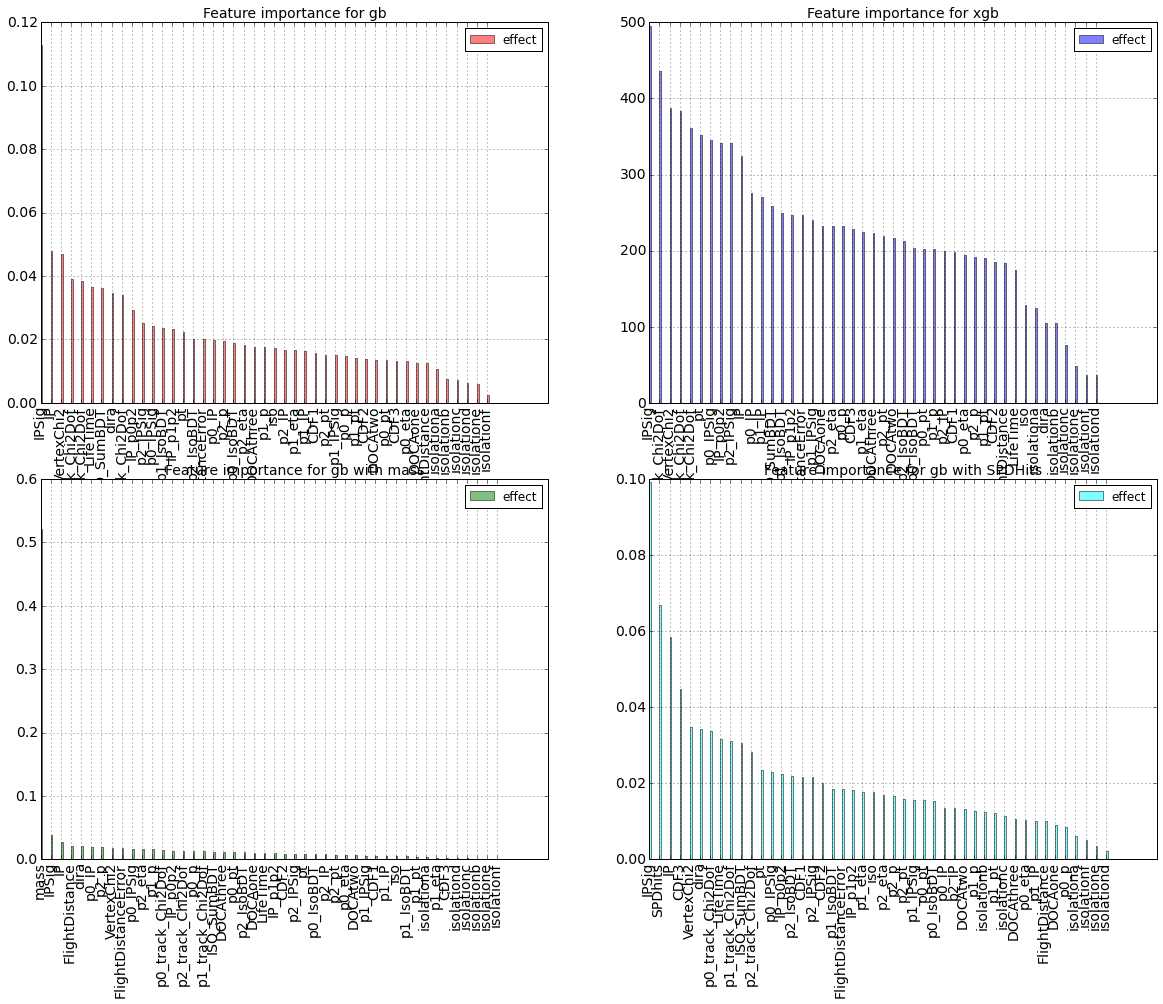

In [14]:
features_importances = report.feature_importance()
features_importances.plot(new_plot=True, figsize=(20, 15))

### ROC curves (receiver operating characteristic)
Plot roc curve for train, test data (it's the same as BackgroundRejection vs Signal Efficiency plot)

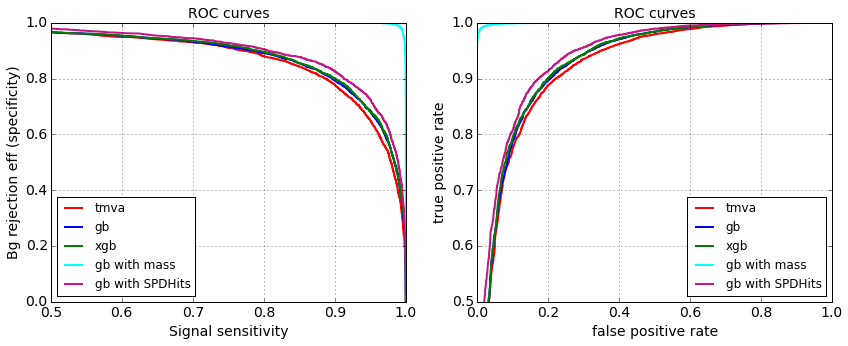

In [15]:
plt.figure(figsize(14, 5))
plt.subplot(1, 2, 1)
report.roc().plot(xlim=(0.5, 1))
plt.subplot(1, 2, 2)
report.roc(physical_notion=False).plot(ylim=(0.5, 1))

In [16]:
# report.roc()

### Plot learning curves to see possible overfitting of trained classifier
Learning curves are powerful and simple tool to analyze the behaviour of your model.

Estimator tmva doesn't support stage predictions


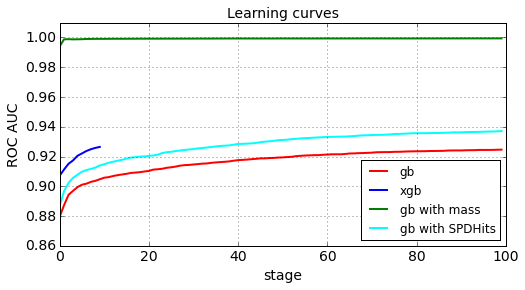

In [17]:
from rep.report.metrics import RocAuc

learning_curve = report.learning_curve(RocAuc(), metric_label='ROC AUC', steps=1)
learning_curve.plot(new_plot=True, figsize=(8, 4), ylim=(0.86, 1.01))

### But our challenge metric is weighted AUC! 

Metric in simplest case may be defined as a function with interface:
```
def function(labels, probabilities, sample_weight=None)

```

Let's use it:

Estimator tmva doesn't support stage predictions


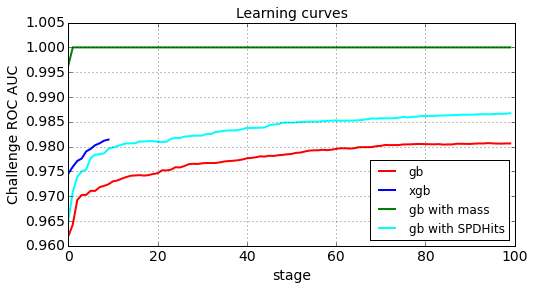

In [18]:
from evaluation import roc_auc_truncated
learning_curve = report.learning_curve(roc_auc_truncated, metric_label='Challenge ROC AUC', steps=1)
learning_curve.plot(new_plot=True, figsize=(8, 4))

### Compute final score

In [19]:
report.compute_metric(roc_auc_truncated)

OrderedDict([('tmva', 0.97998949694030224),
             ('gb', 0.98063574597374226),
             ('xgb', 0.98141197100795408),
             ('gb with mass', 1.0),
             ('gb with SPDHits', 0.9867320179056529)])

### Plot 'flatness' of classifier prediction
(this is dependence of efficiency on variables of dataset)

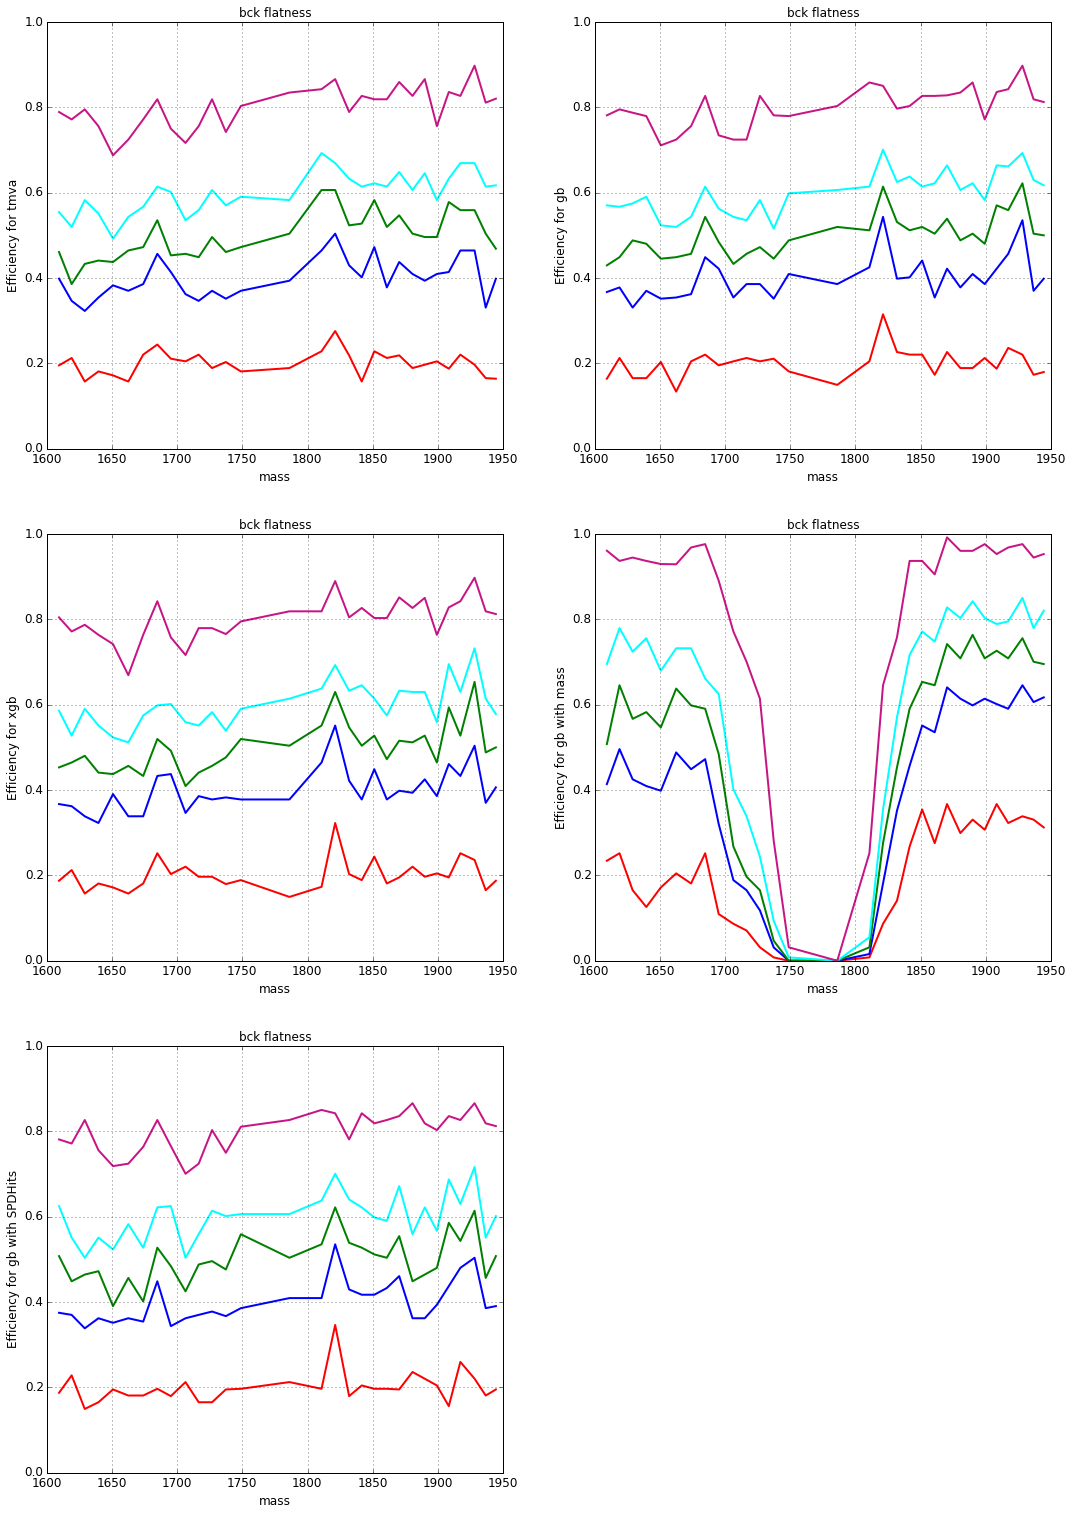

In [20]:
efficiencies = report.efficiencies(['mass'], ignored_sideband=0.01, labels_dict={0: 'bck'})
efficiencies.plot(figsize=(18, 26), fontsize=12, show_legend=False, )

### Let's test models on the Ds data

Remove bad models from factory

In [21]:
factory.pop('gb with mass')
factory.pop('gb')
factory.pop('tmva')
pass

In [22]:
report_ds = factory.test_on(ds_data, ds_labels, ds_weights)

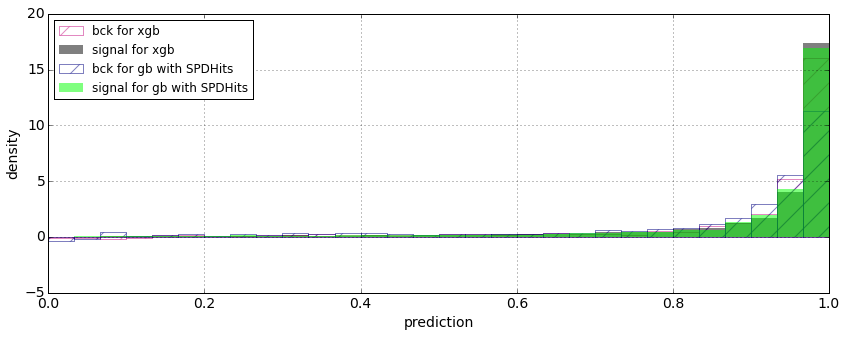

In [23]:
report_ds.prediction_pdf(plot_type='bar', log=True)

In [24]:
def ks_metric(y_true, y_pred, sample_weight=None):
    return ks_2samp_weighted(y_pred[y_true == 0, 1], y_pred[y_true == 1, 1],
                             sample_weight[y_true == 0], sample_weight[y_true == 1])

report_ds.compute_metric(ks_metric)

OrderedDict([('xgb', 0.073658058448765829),
             ('gb with SPDHits', 0.19168349962386166)])

# Advantages of common interface

As one can see above, all the classifiers implement the same interface, 
this simplifies work, simplifies comparison of different classifiers, 
but this is not the only profit. 

`Sklearn` provides different tools to combine different classifiers and transformers. 
One of this tools is `AdaBoost`, which is abstract metaclassifier built on the top of some other classifier (usually, decision dree). Also bagging is other frequently used ensembling meta-algorithm.

Let's show that now you can run AdaBoost over classifiers from other libraries! <br />
_(isn't boosting over neural network what you were dreaming of all your life?)_

In [25]:
from sklearn.ensemble import AdaBoostClassifier
# define base estimators for AdaBoost
tmva_base = TMVAClassifier(method='kBDT',  NTrees=100, MaxDepth=6, 
                           BoostType='Grad', BaggedSampleFraction=0.4, 
                           Shrinkage=0.1, UseRandomisedTrees=True, UseNvars=20, NCuts=-1)

bagging_tmva = SklearnClassifier(AdaBoostClassifier(base_estimator=tmva_base, n_estimators=5, random_state=11),
                                 features=variables)

In [26]:
bagging_tmva.fit(train, train_labels)
report = bagging_tmva.test_on(test, test_labels)

In [27]:
report.compute_metric(roc_auc_truncated)

OrderedDict([('clf', 0.98240946440680721)])

# Other advantages of common interface
There are many things you can do with classifiers now: 
* cloning
* getting / setting parameters as dictionaries 
* automatic hyperparameter optimization 
* build pipelines (`sklearn.pipeline`)
* use hierarchical training, training on subsets
* passing over internet / train classifiers on other machines

And you can replace classifiers at any moment.

# Simple grid search 
In this example we are optimizing
* parameters of GradientBoostingClassifier
* we maximize Challenge RocAuc (= area under the ROC curve)
* using 4 threads (each time we train 4 classifiers)
* we use 3-Folding to estimate quality.
* we use only 30 trees to make examples run fast

In [28]:
from rep.metaml import GridOptimalSearchCV, FoldingScorer, RandomParameterOptimizer

In [29]:
# define grid parameters
grid_param = {}
grid_param['learning_rate'] = [0.2, 0.1, 0.05, 0.02, 0.01]
grid_param['max_depth'] = [2, 3, 4, 5]

# use random hyperparameter optimization algorithm 
generator = RandomParameterOptimizer(grid_param, random_state=11)

# define folding scorer with the Challenge metric
scorer = FoldingScorer(roc_auc_truncated, folds=3, fold_checks=3)

In [30]:
%%time 
estimator = SklearnClassifier(GradientBoostingClassifier(n_estimators=30, subsample=0.5), features=variables)
grid_finder = GridOptimalSearchCV(estimator, generator, scorer, parallel_profile='threads-4')
grid_finder.fit(tau_data, tau_labels)

Performing grid search in 4 threads
4 evaluations done
8 evaluations done
10 evaluations done
CPU times: user 2min 38s, sys: 1.22 s, total: 2min 39s
Wall time: 1min 4s


## Looking at the results

In [31]:
grid_finder.params_generator.print_results()

0.980:  learning_rate=0.2, max_depth=4
0.979:  learning_rate=0.2, max_depth=3
0.979:  learning_rate=0.1, max_depth=5
0.978:  learning_rate=0.2, max_depth=2
0.975:  learning_rate=0.1, max_depth=2
0.973:  learning_rate=0.01, max_depth=4
0.968:  learning_rate=0.02, max_depth=3
0.965:  learning_rate=0.01, max_depth=3
0.958:  learning_rate=0.02, max_depth=2
0.949:  learning_rate=0.01, max_depth=2


# Optimizing models + using custom scorer

__REP__ supports sklearn-way of combining classifiers and getting/setting their parameters.

So you can tune complex models using the same approach. 

In this example:
* we will create new scorer, which test everything on special part of dataset
* we are optimizing Challenge AUC score (if any test is failed then return -2 for correlation, -1 for agreement tests) 
* tuning parameters of TMVA's GBDT
* using GaussianProcesses to make good guesses about next points to check

In [32]:
from sklearn.base import clone
from evaluation import compute_cvm

class ChallengeScorer(object):
    def __init__(self, test_data, test_labels, ds_data, ds_labels, ds_weights):
        self.ds_data = ds_data
        self.ds_labels = ds_labels
        self.ds_weights = ds_weights
        self.test_data = test_data
        self.test_labels = test_labels
        self.correlation_data = test_data[test_labels == 0]
        
    def __call__(self, base_estimator, params, X, y, sample_weight=None):
        cl = clone(base_estimator)
        cl.set_params(**params)
        cl.fit(X, y)
        cvm_value = compute_cvm(cl.predict_proba(self.correlation_data)[:, 1], self.correlation_data['mass'])
        ds_proba = cl.predict_proba(self.ds_data)[:, 1]
        ks_value = ks_2samp_weighted(ds_proba[self.ds_labels == 0], ds_proba[self.ds_labels == 1],
                                     self.ds_weights[self.ds_labels == 0], self.ds_weights[self.ds_labels == 1])
        cvm_loss = (1 if cvm_value > 0.002 else 0.01) * (cvm_value / 0.002)
        ks_loss = (1 if ks_value > 0.09 else 0.01) * (ks_value / 0.09)

        # Returning AUC - cvm_loss - ks_loss
        return roc_auc_truncated(self.test_labels, cl.predict_proba(self.test_data)) - ks_loss - cvm_loss

In [33]:
%%time

from rep.metaml import RegressionParameterOptimizer
from sklearn.ensemble import RandomForestRegressor

# define grid parameters
grid_param = {'Shrinkage': [0.4, 0.2, 0.1, 0.05, 0.02, 0.01], 
              'NTrees': [5, 10, 15, 20, 30], 
              # you can pass different sets of features to be compared
              'features': [variables, variables + ['SPDhits']],
             }

generator = RegressionParameterOptimizer(grid_param, n_evaluations=10, regressor=RandomForestRegressor(),
                                         n_attempts=10, random_state=11)

# define folding scorer
scorer = ChallengeScorer(test, test_labels, ds_data, ds_labels, ds_weights)

grid_finder = GridOptimalSearchCV(TMVAClassifier(method='kBDT', BoostType='Grad',), 
                                  generator, scorer, parallel_profile='threads-3')
grid_finder.fit(train, train_labels)

Performing grid search in 3 threads
3 evaluations done
6 evaluations done
9 evaluations done
12 evaluations done
CPU times: user 50.5 s, sys: 3.05 s, total: 53.5 s
Wall time: 2min 7s


In [34]:
grid_finder.params_generator.print_results()

0.965:  Shrinkage=0.4, NTrees=30, features=['FlightDistanceError', 'IP', 'CDF1', 'p2_IPSig', 'p0_IP', 'DOCAone', 'p0_IPSig', 'DOCAtwo', 'p0_eta', 'p0_track_Chi2Dof', 'LifeTime', 'IPSig', 'p2_pt', 'FlightDistance', 'p0_IsoBDT', 'pt', 'p2_IsoBDT', 'p1_track_Chi2Dof', 'isolationc', 'p1_pt', 'p1_p', 'DOCAthree', 'IP_p1p2', 'isolationb', 'p0_p', 'isolationa', 'isolationf', 'isolationd', 'isolatione', 'dira', 'CDF3', 'CDF2', 'p0_pt', 'ISO_SumBDT', 'IP_p0p2', 'p2_p', 'p1_IP', 'VertexChi2', 'p2_track_Chi2Dof', 'p1_IsoBDT', 'p2_eta', 'p1_eta', 'p2_IP', 'iso', 'p1_IPSig']
0.963:  Shrinkage=0.4, NTrees=20, features=['FlightDistanceError', 'IP', 'CDF1', 'p2_IPSig', 'p0_IP', 'DOCAone', 'p0_IPSig', 'DOCAtwo', 'p0_eta', 'p0_track_Chi2Dof', 'LifeTime', 'IPSig', 'p2_pt', 'FlightDistance', 'p0_IsoBDT', 'pt', 'p2_IsoBDT', 'p1_track_Chi2Dof', 'isolationc', 'p1_pt', 'p1_p', 'DOCAthree', 'IP_p1p2', 'isolationb', 'p0_p', 'isolationa', 'isolationf', 'isolationd', 'isolatione', 'dira', 'CDF3', 'CDF2', 'p0_pt',

# Summary
Grid search in __REP__ extends sklearn grid search, uses optimization techniques to avoid complete search of estimator parameters. 

__REP__ has predefined scorers, metric functions, optimization techniques. Each component is replaceable and you can optimize complex models and pipelines (Folders/Bagging/Boosting and so on). 

## Structure together
* _ParameterOptimizer_ is responsible for generating new set of parameters which will be checked
  * RandomParameterOptimizer
  * AnnealingParameterOptimizer
  * SubgridParameterOptimizer
  * RegressionParameterOptimizer (this one can use any regression model, like GaussianProcesses)
  
* _Scorer_ is responsible for training and evaluating metrics
  * Folding scorer (uses metrics with __REP__ interface), uses averaging quality after kFolding
  
* _GridOptimalSearchCV_ makes all of this work together and sends tasks to IPython cluster or separate threads.




# Folding Strategy

REP implements folding strategy as one more metaestimator.

When we don't have enough data to split data on train/test, we're stick to k-folding cross-validation scheme.
Folding becomes the only way when you use some multi-staged stacking algorithm.

Usually we split training data into folds manually, but this is annoying (and not reliable). REP has FoldingClassifier and FoldingRegressor, which do this automatically.

In [35]:
from hep_ml.nnet import MLPClassifier
from rep.metaml import FoldingClassifier

In [36]:
%%time
# train NN on the full data to obtain it as a feature for further training
folder = FoldingClassifier(MLPClassifier(layers=(30, 10), epochs=100, random_state=11), 
                           n_folds=3, features=variables)
folder.fit(tau_data, tau_labels)

CPU times: user 16.1 s, sys: 6.53 s, total: 22.6 s
Wall time: 14.5 s


## Default prediction (predict i_th_ fold by i_th_ classifier)

In this case each sample will be predict by estimator that was not using this particular sample in training. 

When you apply this prediction to some new data (not the same was passed in training), it will predict each sample by random estimator.

In [37]:
roc_auc_truncated(tau_labels, folder.predict_proba(tau_data))

KFold prediction using folds column


0.98160799041427405

## Voting prediction 

When predicting new data, we can predict each fold by *all classifiers* and take value, which is calculated by `vote_function`.

It makes sense to use all classifier to predict new data, because averaging makes predictions more stable.

In [38]:
# definition of mean function, which combines all predictions
def mean_vote(x):
    return numpy.mean(x, axis=0)

In [39]:
ds_proba = folder.predict_proba(ds_data, vote_function=mean_vote)[:, 1]
ks_2samp_weighted(ds_proba[ds_labels == 0], ds_proba[ds_labels == 1],
                  ds_weights[ds_labels == 0], ds_weights[ds_labels == 1])

KFold prediction with voting function


0.065367394863654837